In [9]:
from functools import partial
from pathlib import Path

import os

In [10]:
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [13]:
tf.random.set_seed(2020)

In [50]:
from dotenv import load_dotenv

In [51]:
load_dotenv(".env", override=True)

False

# The Data
Tensorflow includes the MNIST data set that we can grab with the load_data function. It returns two tuples of numpy arrays.

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [15]:
rows, width, height = x_train.shape
print(f"Training:\t{rows:,} images\timage = {width} x {height}")
rows, width, height = x_test.shape
print(f"Testing:\t{rows:,} images\timage = {width} x {height}")

Training:	60,000 images	image = 28 x 28
Testing:	10,000 images	image = 28 x 28


# The Distribution
First, we can look at the distribution of the digits to see if they are equally represented.

   Digit  Count
0      5   5421
1      0   5923
2      4   5842
3      1   6742
4      9   5949
5      2   5958
6      3   6131
7      6   5918
8      7   6265
9      8   5851


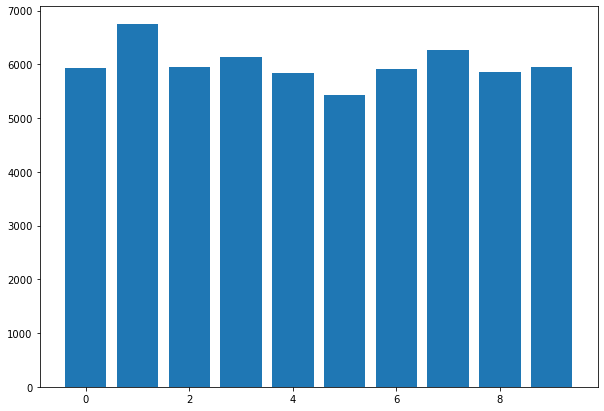

In [19]:
labels = (pd.Series(y_train).value_counts(sort=False)
          .reset_index()
          .rename(columns={"index": "Digit",
                           0: "Count"}))

print(labels)

# Figure Size
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(labels.Digit, labels.Count)
 
# Show Plot
plt.show()

If you look at the values for the counts you can see that there is a pretty significant difference between 1 and 5. (the indexes for 1 and 5, are 3 and 0 respectively, see above) 

In [30]:
print(f"{int(labels.iloc[3].Count - labels.iloc[0].Count):,}")

1,321


But we're doing this as an exercise to get a web-page up more so than build a real model so let's not worry about that for now.

# Some Example Digits
We'll make a 4 x 4 grid of the first 16 images to see what they look like. Note that our array uses 0-based indexing but matplotlib uses 1-based indexing so we have to make sure that the reference to the cell in the subplot is one ahead of the index for the array.

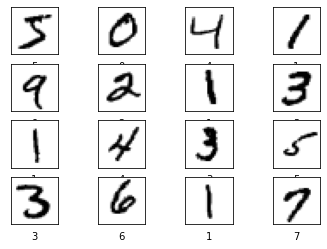

In [31]:
IMAGES = 16
ROWS = COLUMNS = 4

for index in range(IMAGES):
    plt.subplot(ROWS, COLUMNS, index + 1)
    plt.imshow(x_train[index], cmap='binary')
    plt.xlabel(str(y_train[index]))
    plt.xticks([])
    plt.yticks([])
plt.show()

So the digits (at least the first 16) seem to be pretty clear.

# Normalizing the Data
One problem we have, though, is that images use values from 0 to 255 to indicate the brightness of a pixel, but neural networks tend to work better with values from 0 to 1, so we'll have to scale the data back. The images are also 28 x 28 squares, but we need to transform them to flat vectors. We can change the shape of the input data using the numpy.reshape function, which takes the original data and the shape you want to change it to. In our case we want the same number of rows that there were originally and we want to reduce the images from 2-dimensional images to 1-dimensional images which we can do by passing in the number of total number of pixels in each image as a single number instead of width and height.

Since we have to do this for both the training and testing data, I'll make a helper function.

In [32]:
def normalize(data: np.array) -> np.array:
    """reshapes the data and scales the values"""
    rows, width, height = data.shape
    pixels = width * height
    data = np.reshape(data, (rows, pixels))

    assert data.shape == (rows, pixels)

    MAX_BRIGHTNESS = 255
    data = data / MAX_BRIGHTNESS

    assert data.max() == 1
    assert data.min() == 0
    return data

In [33]:
x_train = normalize(x_train)
x_test = normalize(x_test)

# The Neural Network Model
## Build and Train It
Now we'll build the model. It's going to be a simple fully-connected network with three layers (input, hidden, output). To make the visualization simpler we'll use the sigmoid activation function.

Besides the shallowness of the model it's also going to be relatively simple, with only 32 nodes in the hidden layer.

First we'll build it as a Sequential (linear stack) model.

In [34]:
rows, pixels = x_train.shape
HIDDEN_NODES = 32
CATEGORIES = len(labels)
ACTIVATION = "sigmoid"
OUTPUT_ACTIVATION = "softmax"

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(HIDDEN_NODES,
                        activation=ACTIVATION,
                        input_shape=(pixels,)),
    tf.keras.layers.Dense(HIDDEN_NODES,
                        activation=ACTIVATION),
    tf.keras.layers.Dense(CATEGORIES,
                        activation=OUTPUT_ACTIVATION)
])

Now we can compile the model using a sparse categorical cross-entropy loss function, which is for the case where you have more than one category (non-binary) and the Adam optimizer.

In [35]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

And next we'll train the model by calling its fit method.

In [36]:
NO_OUTPUT = 0
EPOCHS = 40
BATCH_SIZE = 2048

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=NO_OUTPUT
)

2022-09-22 14:37:24.053028: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


# Plot the Training History

In [37]:
history = pd.DataFrame.from_dict(history.history)
history = history.rename(
    columns={
        "loss": "Training Loss",
        "accuracy": "Training Accuracy",
        "val_loss": "Validation Loss",
        "val_accuracy": "Validation Accuracy",
    })

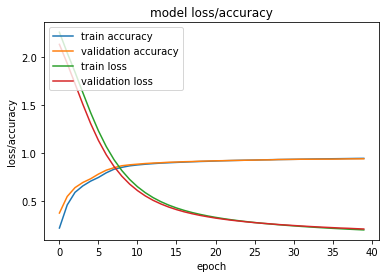

In [46]:
# summarize history for accuracy and loss
plt.plot(history['Training Accuracy'])
plt.plot(history['Validation Accuracy'])
plt.plot(history['Training Loss'])
plt.plot(history['Validation Loss'])
plt.title('model loss/accuracy')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy', 'train loss', 'validation loss'], loc='upper left')
plt.show()


In [47]:
for column in history.columns:
    lowest = history[column].min()
    highest = history[column].max()
    print(f"({column}) Min={lowest:0.2f} Max={highest: 0.2f}")

(Training Loss) Min=0.20 Max= 2.26
(Training Accuracy) Min=0.22 Max= 0.95
(Validation Loss) Min=0.21 Max= 2.14
(Validation Accuracy) Min=0.38 Max= 0.94


So our validation accuracy goes from 38% to 94%, which isn't bad, especially when you consider what a simple model we have.

# Save It
Now we can save the model to use in our application.

Note To Self: Since this is being run on a remote machine, both the .env file and the directory to save the models refers to the remote machine, not the local machine where this file is being edited, so you have to copy it to the local machine later on to use it.

Also note that the you can't see the name since I put it in a .env file, but it has .h5 as the extension. According to the TensorFlow page on saving and loading a model, H5 is the older format, they've switched to the SavedModel format, you lose some information that would help you resume training, but we're not going to do that anyway, and the H5 format should be a little smaller.

Most of the next blob is to make sure the folder for the model exists. I put it in the environment variable mostly because I keep changing my mind as to where to put it and what to call it.

In [53]:
model.save("tf_MNIST_app")

INFO:tensorflow:Assets written to: tf_MNIST_app/assets
